# Land Cover Classification of Satellite Images Using Machine Learning

***Author:*** Dustin Littlefield \
***Date:*** 07/01/2025

## 1. Objective

This project applies machine learning to satellite imagery in order to classify land into four types: barren, trees, grassland, and other. The goal is to compare the performance of two approaches:

1. A **Convolutional Neural Network (CNN)** trained directly on 4-band image data (with optional NDVI)
2. A **Random Forest classifier** trained on flattened pixel values and derived features

We evaluate performance using accuracy, precision, recall, F1-score, and training curves — and explore how NDVI and class balancing affect results.

## 2. Tools and Libraries

***Tools:*** Python, TensorFlow, Scikit-learn, Pandas, NumPy, Matplotlib, Seaborn
Techniques: CNN, Random Forest, Ensemble Learning, NDVI Feature Engineering
Dataset: DeepSat (SAT-4) - Kaggle / NAIP (National Agriculture Imagery Program)
Project Type: Image Classification, Geospatial Data, Machine Learning

### Libraries:

In [38]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning (Random Forest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep learning (CNN)
import tensorflow as tf
#from tensorflow.keras import layers, models, Input
from tensorflow.keras import models, layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Utility
import random
import warnings
import time
from IPython.display import clear_output
warnings.filterwarnings('ignore')


## 3. Dataset Overview and Loading

 * **Dataset:** DeepSat (SAT-4) Airborne Dataset<br>
 * **Posted by:** Chris Crawford<br>
 * [Kaggle Dataset](https://www.kaggle.com/datasets/crawford/deepsat-sat4/data?select=sat4annotations.csv)<br>
 
 The dataset contains pixel data for satellite images, with each image resized to 28x28 pixels and comprising 4 channels. The orginal sattelite images was gathered from the National Agriculture Imagery Program (NAIP) dataset. A team split the images and classified the data. Provided is the 500,000 flattened 28 x 28 sized classified images in a .csv file format

I use a subset of the **DeepSat SAT-4** dataset, which consists of 28×28 pixel satellite images with 4 spectral bands:

 * **Channel 1** - red<br>
 * **Channel 2** - green<br>
 * **Channel 3** - blue<br>
 * **Channel 4** - near infrared<br>
 
 Each image is classified to one of four land cover classes:
- `0`: Barren  
- `1`: Trees  
- `2`: Grassland  
- `3`: Other

The original SAT-4 dataset contains over 500,000 satellite images. Due to computing limitations, I initially worked with a subset of 2,000 images. After experimentation, I found that increasing the sample size improved model performance, and ultimately settled on 10,000 images for the final model training and evaluation.

For GitHub hosting purposes, this repository includes a **downsized version with 1,000 images** to reduce file size. The code remains compatible with larger datasets if needed.

The data is stored in flattened CSV format:
- `sat_images.csv`: 1000 images (each with 3136 pixel values = 28×28×4)
- `labels.csv`: One-hot encoded labels

In [2]:
sat_images = pd.read_csv('sat_images.csv')
labels = pd.read_csv('labels.csv')

## 4. Image Preprocessing and NDVI Calculation

The pixel data was initially stored in a flattened array of shape `(10000, 3136)`, representing 10,000 images of size 28×28×4 (RGB + NIR). To prepare it for input into a convolutional neural network (CNN), I:

- Normalize all pixel values to a 0–1 range  
- Reshape each row into a 3D image tensor of shape `(28, 28, 4)`  
- Combine all images into a single NumPy array for modeling

In [3]:
# Normalize and reshape all image rows at once
num_images = sat_images.shape[0]
reshaped_images = sat_images.values / 255.0
reshaped_images = reshaped_images.reshape((num_images, 28, 28, 4))

print("Image array shape:", reshaped_images.shape)

Image array shape: (1000, 28, 28, 4)


#### NDVI (Normalized Difference Vegetation Index)

The NDVI is a widely used index in remote sensing to analyze vegetation. It is calculated using the near-infrared (NIR) and red bands of satellite images. The formula for NDVI is:

${\huge}NDVI = \frac{NIR - Red}{NIR + Red}$
 
Where:

- **NIR** = Band 4 (Near-Infrared)
- **Red** = Band 1 (Red)

NDVI values range from -1 to 1, with higher values indicating more vegetation and lower values representing non-vegetative features. Including this measure will help the model differentiate barren features from grasslands or trees.<br>

#### NDVI Calculation:


In [4]:
def add_NDVI(images):

    # Compute the NDVI and append the result as a 5th channel for each image in the array.
    # Assumes image_array shape = (N, 28, 28, 4), with Red at index 0 and NIR at index 3.
    # Returns: (N, 28, 28, 5)
    
    red = images[:,:,:,0]
    NIR = images[:,:,:,3]
    epsilon = 1e-6  # add a small value to prevent division by zero
    
    NDVI = (NIR - red) / (NIR + red + epsilon) # NDVI calculation
    
    # Add an extra channel for the NDVI and concatenate with the original image data
    ndvi_expanded = np.expand_dims(NDVI, axis=-1)  # New shape = (1500, 28, 28, 1)
    combined_data = np.concatenate([images, ndvi_expanded], axis=-1)
    
    return combined_data

In [5]:
# add the NDVI channel to all of the images
five_channel = add_NDVI(reshaped_images)

## 5. Label Processing and Class Distribution

The label data is provided in a **one-hot encoded format**, where each row corresponds to one of the four land cover classes:

- **Barren** → [1, 0, 0, 0]  
- **Trees** → [0, 1, 0, 0]  
- **Grassland** → [0, 0, 1, 0]  
- **Other** → [0, 0, 0, 1]  

We convert each one-hot vector to its corresponding class index (`0–3`) and class name using a simple mapping function.

In [6]:
# a simple function to name a class
def class_name(y_value):
    return ['barren', 'trees', 'grass', 'other'][y_value]

To get a better understanding of the distribution of the labels in the dataset and hence the distribution of images, I calculate the count of each class. Both grasslands and trees are under represented in the data.

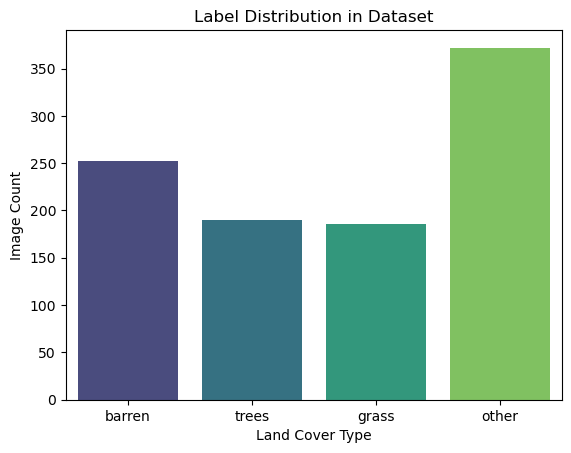

In [7]:
label_distribution = { # build counts of each type in a dataset
    'Land Type': ['barren', 'trees', 'grass', 'other'],
    'Count': [(labels.iloc[:, 0] == 1).sum(),(labels.iloc[:, 1] == 1).sum(),(labels.iloc[:,2] == 1).sum(),(labels.iloc[:, 3] == 1).sum()]
}

#pd.DataFrame(data) # display a simple chart with distribution of each land type

sns.barplot(x='Land Type', y='Count', data=label_distribution, palette='viridis')
plt.title("Label Distribution in Dataset")
plt.ylabel("Image Count")
plt.xlabel("Land Cover Type")
plt.show()

## 6. Sample images:

To showcase the variety in the dataset, I display a random subset of images in a grid format. The image brightness is slightly adjusted to improve visual clarity. This visualization highlights the diversity in land cover as well as variations in image quality—some samples appear noisier or more textured than others.

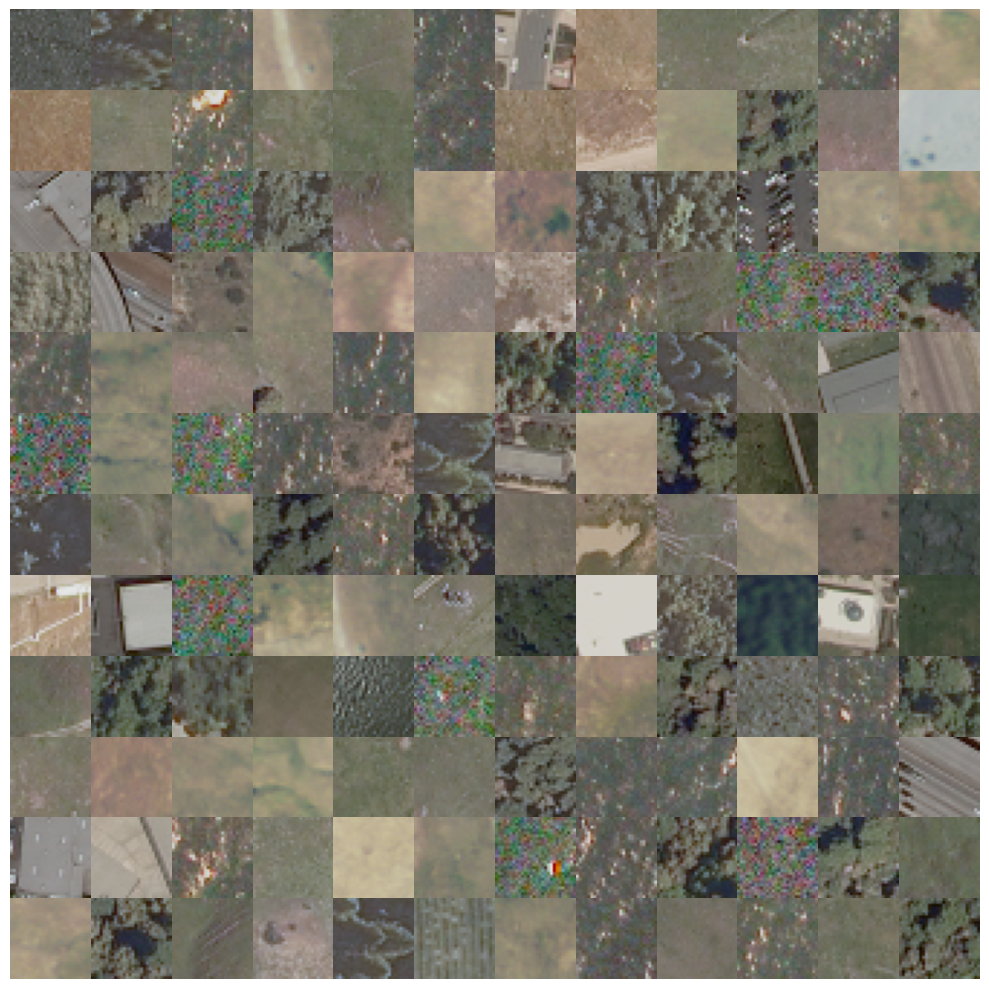

In [8]:
# select 144 random samples of images to display
indices = np.random.choice(reshaped_images.shape[0], size=144, replace=False) 

# Extract RGB channels only and slightly darken for visual clarity
grid_display = reshaped_images[indices, :, :, :3] * .9

# grid layout
grid_size = (12, 12)
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
axes = axes.flatten()

# Iterate through each image and subplot axis, displaying the image
for i, ax in enumerate(axes):
    ax.imshow(grid_display[i])  # Display image
    ax.axis('off')         # Hide axes

# Display the plot
plt.tight_layout()  # Adjust layout so the images fit nicely
plt.subplots_adjust(wspace=0, hspace=0)  # Set both horizontal and vertical space to 0
plt.show()

## 7. Train-test split

Before training, we convert the image and label data into NumPy arrays. The dataset is then split into **training (70%)** and **testing (30%)** subsets.

We also store copies of the training and test sets for use in comparing different modeling approaches (e.g., CNN vs. Random Forest) later in the notebook.

In [9]:
# Convert to NumPy arrays (if not already)
five_channel = np.array(five_channel)
labels = np.array(labels)

# split the sample
X_train, X_test, y_train, y_test = train_test_split(five_channel, labels, test_size=0.3)

# copies of the data
combined_X_train, combined_X_test, combined_y_train, combined_y_test = X_train, X_test, y_train, y_test
X_train_rf, X_test_rf, y_train_rf, y_test_rf = X_train, X_test, y_train, y_test

# Confirm shapes
print("Training images:", X_train.shape)
print("Training labels:", y_train.shape)
print("Test images:", X_test.shape)
print("Test labels:", y_test.shape)

Training images: (700, 28, 28, 5)
Training labels: (700, 4)
Test images: (300, 28, 28, 5)
Test labels: (300, 4)


## 8. Handling Class Imbalance with Weights

As shown in the earlier class distribution chart, the dataset is imbalanced—**trees** and **grassland** appear less frequently than **barren** or **other**. To address this, we compute class weights for model training.


The formula used for weighting is:

**weight₍ᵢ₎** = *n* / (*num_classes* × *nᵢ*)

Where:  
- *n* = total number of samples  
- *num_classes* = total number of classes (4)  
- *nᵢ* = number of samples in class *i*

These weights help the model give more importance to underrepresented classes during training.



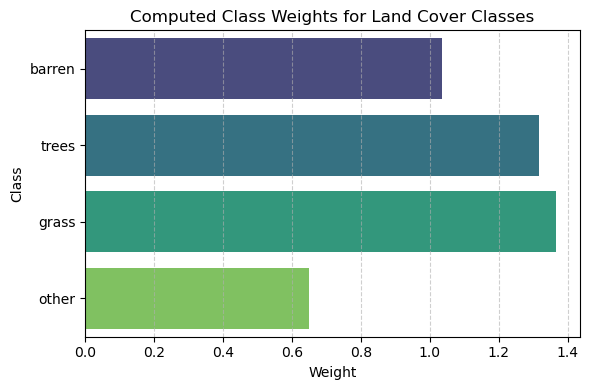

In [10]:
# Get the class labels as a 1D array (this simplifies the class labels, so they are not one-hot encoded)
y_train_simple, t_test_simple = np.argmax(y_train, axis = 1), np.argmax(y_test, axis = 1)

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train_simple), 
                                     y=y_train_simple)

# Convert to a dictionary for Keras
class_weights  = {
    0: class_weights[0],
    1: class_weights[1],
    2: class_weights[2],
    3: class_weights[3]
}

# Prepare data for plotting
label_names = ['barren', 'trees', 'grass', 'other']
weights_df = pd.DataFrame({
    'Class': label_names,
    'Weight': [class_weights[i] for i in range(len(label_names))]
})

# Plot horizontal bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x='Weight', y='Class', data=weights_df, palette='viridis')
plt.title("Computed Class Weights for Land Cover Classes")
plt.xlabel("Weight")
plt.ylabel("Class")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 9. Convolutional Neural Network (CNN) Overview

Convolutional Neural Networks (CNNs) are powerful models for image classification tasks. In this project, we use a CNN to classify satellite imagery into four land cover classes: **barren**, **trees**, **grassland**, and **other**.

The model processes input images using multiple layers that extract features and make predictions based on spatial patterns. The input has 5 channels (Red, Green, Blue, Near-Infrared, and NDVI).

---

<details>
<summary><strong>📖 Click to expand: How CNNs Work</strong></summary>

### What is a CNN?

A convolutional neural network(CNN) is a specialized network for the identification of features in images. It excels at detecting edges, features, and objects in images.

---

### Layers of a CNN

#### Convolutional Layers  
In a CNN, this layer is used to identify features in an image like edges, corners, textures, and shapes. It works by sweeping a smaller matrix (in this case 3 x 3) along the pixel data. For each pixel, it will calculate the **dot product** of the pixel value along with its surrounding pixels values **(local region)** with the filter matrix. This product will them be placed in the pixels position in a feature map of the image. The shape of the resulting output matrix depends on the use of padding. After the convolution operation, a *bias* term is added to the resulting dot product and then passed through the *activation function*.

- **Valid padding**: No padding; image shrinks with each layer  
- **Same padding**: Adds zero-padding so output size matches input (increases computation)

> Example:
    
$$
\overset{\text{Filter}}{\begin{pmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{pmatrix}}
\quad \text{sweeping while applying dot multiplication} \quad
\overset{\text{Image (with padding)}}{\begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 1 & 2 & 3 & 0 \\
0 & 4 & 5 & 6 & 0 \\
0 & 7 & 8 & 9 & 0 \\
0 & 0 & 0 & 0 & 0
\end{pmatrix}}
\quad \text{=} \quad
\overset{\text{Output}}{\begin{pmatrix}
94 & 186 & 106 \\
154 & 285 & 154 \\
106 & 186 & 94
\end{pmatrix}}
$$

---

#### Pooling Layers  
Reduce the size of feature maps by selecting the **maximum** value in small 2×2 windows — helps reduce noise and overfitting.

> Example:
$$
\overset{\text{Filter shape:}}{\begin{pmatrix}
a & b \\
c & d
\end{pmatrix}}
\quad \text{while sweeping takes max of:} \quad
\overset{\text{Feature Map:}}{\begin{pmatrix}
94 & 186 & 106 \\
154 & 285 & 154 \\
106 & 186 & 94
\end{pmatrix}}
\quad \text{=} \quad
\overset{\text{Output:}}{\begin{pmatrix}
285 & 285 \\
285 & 285
\end{pmatrix}}
$$

---

#### Flatten Layer  
Converts 3D feature maps into a 1D array for input into fully connected layers.

---

#### Dense Layers  
Dense layers take the output from the previous convolution and pooling layers — now flattened into a 1D vector — and use it to make predictions. These layers work just like a traditional neural network:

- Each neuron receives input from **all** values in the flattened vector
- The first dense layer helps **combine spatial features** into meaningful patterns
- The final dense layer has **4 output nodes**, one for each land cover class
- A **softmax activation** is applied to convert raw scores into probabilities that sum to 1


---

### Model Compilation

- **Loss function**: `categorical_crossentropy` (multi-class classification)  
- **Optimizer**: `adam` (adaptive gradient descent)  
- **Class weighting**: Used to handle class imbalance  
- **Metrics**: Accuracy, precision, recall

</details>


# Define the model
cnn_model = models.Sequential([
    layers.Input(shape=(28, 28, 5)),
    layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu',padding='same'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Multi-class classification loss
              metrics=['accuracy'])

# Summary of the model architecture
cnn_model.summary()

In [11]:
# Define Functional model with named input
input_layer = Input(shape=(28, 28, 5), name="input")

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
flatten_output = layers.Flatten(name="flatten")(x)
x = layers.Dense(256, activation='relu')(flatten_output)
output_layer = layers.Dense(4, activation='softmax', name="output")(x)

# Build model
cnn_model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 28, 28, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,584,516 (13.67 MB)

 Trainable params: 3,584,516 (13.67 MB)

 Non-trainable params: 0 (0.00 B)

## 10. Hyperparameter Tuning

To improve model performance and reduce overfitting, I conducted a series of experiments on a 1,000-image subset of the dataset. The experiments tested variations in:

- **Batch size**
- **Number of epochs**
- **Optimizer function**
- **Activation function**
- **Use of early stopping**

After extensive testing, I found that:
- A **batch size of 16** consistently performed well across different conditions
- Running the model for **more than 50 epochs** did not significantly improve accuracy
- The **ReLU** activation function outperformed **tanh**, likely because most pixel values (RGB + NIR) are positive
- The **Adam** optimizer was most effective, though RMSprop performed similarly
- Early stopping helped reduce overfitting and unnecessary training time

In [12]:
# define early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',         # monitor change in loss function
    patience = 5,                 # Number of epochs to wait before stopping
    restore_best_weights = True,  # Restore the best weights after early stopping
    verbose = 0                   # Dont Show the message when early stopping is triggered
)

The plots below compare the model's training history **with and without early stopping**. It is clear that beyond approximately **15 epochs**, the validation loss begins to increase, indicating overfitting. Early stopping halts training at the optimal point and restores the best-performing weights.

> **Note:** These graphs were generated using the full 10,000-image dataset. On smaller subsets (such as 1,000 images), early stopping is less consistent due to limited validation data and quicker convergence. However, the full dataset more clearly illustrates the benefit of early stopping in preventing overtraining.

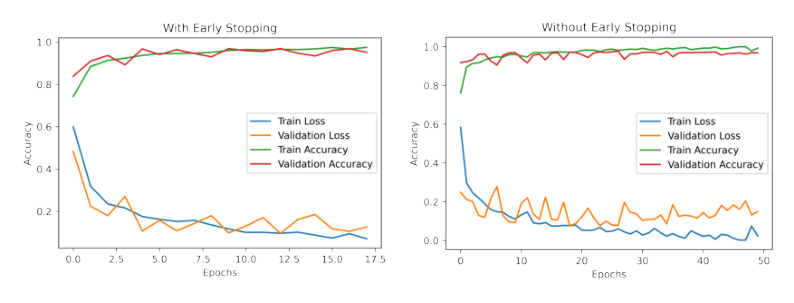

In [13]:
img = plt.imread('es_final.png')

fig, axes = plt.subplots(figsize=(10,8))
axes.imshow(img)
axes.axis('off')  # Optional: remove axis ticks
plt.show()

### Top Experiment Results

The table below shows the top 10 performing configurations, ranked by **test accuracy**. These results are drawn from a larger experiment log (`combined_data.csv`), included with this project.

**Note:** Model **102** was selected for final training based on its combination of **high accuracy**, **low loss**, and the use of **early stopping** to prevent overfitting and reduce runtime.


In [14]:
rankings = pd.read_csv("combined_data.csv")
best_accuracy = rankings.sort_values(by='test_accuracy', ascending=False)
best_accuracy.head(10)

,epochs,batch_size,test_loss,test_accuracy,early,activation,optimizer
19,100,16,0.454715,0.933333,No,relu,adam
7,100,16,0.379847,0.930000,No,relu,adam
102,50,16,0.203395,0.930000,Yes,relu,adam
163,100,16,0.253807,0.926667,Yes,relu,rmsprop
98,50,32,0.206431,0.926667,Yes,relu,adam
2,50,32,0.463423,0.923333,No,relu,adam
3,100,32,0.311642,0.923333,No,relu,adam
9,20,8,0.255080,0.923333,No,relu,adam
122,50,32,0.254760,0.923333,Yes,tanh,adam
5,20,16,0.233364,0.920000,No,relu,adam


#### Data structure to hold metrics

In [15]:
# Define the metrics and methods
metrics = ['accuracy', 'precision', 'recall', 'f1-score']
methods = ['CNN', 'Random Forest', 'Ensemble']

# Create an empty DataFrame to hold the metrics for each class and method
data = {
    'Metric': metrics,
    'barren': None,
    'trees': None,
    'grass': None,
    'other': None,
}

## 11. CNN Model Training and Evaluation

The final CNN model is trained using the optimal hyperparameters determined through prior experimentation:

- **Epochs:** 50 maximum
- **Batch size:** 16
- **Optimizer:** Adam
- **Activation function:** ReLU
- **Loss function:** Categorical Crossentropy
- **Class weights:** Used to correct for class imbalance
- **Early stopping:** Included to prevent overfitting

In [16]:
# Fit the CNN model with optimum parameters

history = cnn_model.fit(
    X_train, y_train,                     # Training data and labels
    epochs=50,                           # optimum number of epochs
    batch_size=16,                        # optimum batch size
    validation_data=(X_test, y_test),     # data to validate after each epoch
    callbacks=[early_stopping],           # early stopping included
    verbose = 0,                          # hide outputs 
    class_weight = class_weights          # add class weighting
)


### Stand Alone CNN Metrics

In [17]:
# Predict the class probabilities for the test data
y_pred = cnn_model.predict(X_test)

# Evaluate the model on the test data
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

# Get the predicted class
y_pred = np.argmax(y_pred, axis=1)  # Shape: (num_samples,)

# Convert one-hot encoded y_test to class indices using np.argmax
y_test_class = np.argmax(y_test, axis=1)

# build a confusion matrix to calculate accuracy for each class
cm = confusion_matrix(y_test_class, y_pred)
accuracy = np.diag(cm) / cm.sum(axis=1)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test_class, y_pred, average=None)  # per class precision
recall = recall_score(y_test_class, y_pred, average=None)  # per class recall
f1 = f1_score(y_test_class, y_pred, average=None)  # per class f1-score

# build new dataframe and populate with metrics
CNN_metrics_df = pd.DataFrame(data)

for i in range(4):
    CNN_metrics_df.iloc[0,i+1] = accuracy[i]
    CNN_metrics_df.iloc[1,i+1] = precision[i]
    CNN_metrics_df.iloc[2,i+1] = recall[i]
    CNN_metrics_df.iloc[3,i+1] = f1[i]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9180 - loss: 0.1858


## 12. Standalone Random Forest Model

As a baseline comparison to the CNN, I trained a **Random Forest classifier** directly on the image data.

Since Random Forests cannot process image tensors, the input images are first **flattened** into 1D feature vectors. Class labels are converted from one-hot encoding to class indices.

The model is evaluated using:
- A **confusion matrix**
- **Per-class accuracy**
- **Precision**, **recall**, and **F1-score**

This standalone model provides insight into how well a traditional machine learning method performs on this type of spatial data, without the benefit of learned features.


In [18]:
# Get the class for test and train data to work with Random Forest
y_train_rf = np.argmax(y_train_rf, axis = 1)
y_test_rf = np.argmax(y_test_rf, axis = 1)

# flatten the image data to fit the Random Forest Method
flat_X_train_rf = np.reshape(X_train_rf, (X_train_rf.shape[0], -1))
flat_X_test_rf = np.reshape(X_test_rf, (X_test_rf.shape[0], -1))

# Build and train standalone Random Forest model
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    class_weight='balanced',
    random_state=42
)

rf.fit(flat_X_train_rf, y_train_rf)

# Make predictions
y_pred_rf = rf.predict(flat_X_test_rf)

# build a confusion matrix and calculate accuracy for each class
cmat = confusion_matrix(y_test_rf, y_pred_rf)
accuracy = np.diag(cmat) / cmat.sum(axis=1)

# Calculate precision, recall, and f1 for each class
precision = precision_score(y_test_rf, y_pred_rf, average=None)
recall = recall_score(y_test_rf, y_pred_rf, average=None)
f1 = f1_score(y_test_rf, y_pred_rf, average=None) 

# build new dataframe and populate with metrics
Random_metrics_df = pd.DataFrame(data)

for i in range(4):
    Random_metrics_df.iloc[0,i+1] = accuracy[i]
    Random_metrics_df.iloc[1,i+1] = precision[i]
    Random_metrics_df.iloc[2,i+1] = recall[i]
    Random_metrics_df.iloc[3,i+1] = f1[i]

## 13. Ensemble Random Forest Classifier

To explore an alternative modeling strategy, I use a **Random Forest classifier** trained on features extracted by the CNN. Instead of using the raw images, I extract the output of the CNN’s **flatten layer** (just before the final dense prediction layer). These 1D feature vectors represent spatially abstracted information learned by the convolutional filters.

The goal is to address certain weaknesses observed in the CNN predictions — particularly the **confusion between grassland and barren land**, which will be evaluated later.

For the Random Forest, I use:
- `n_estimators=500` to create a deep forest with a strong ensemble
- `max_depth=20` to reduce overfitting and maintain generalization
- `class_weight='balanced'` to account for class imbalance


In [19]:
# extract output of flattened dense layer to use in random forest model
feature_model = models.Model(inputs=cnn_model.input, outputs=flatten_output)

# construct the random forest model
ensemble = RandomForestClassifier(n_estimators=500,max_depth=20,class_weight = 'balanced')

In [20]:
# Extract features from the training and test data to use in random forest model
train_features = feature_model.predict(combined_X_train)
val_features = feature_model.predict(combined_X_test)

#simplipfy classification vectors
combined_y_test = np.argmax(combined_y_test, axis = 1)
combined_y_train = np.argmax(combined_y_train, axis = 1)

# fit 
ensemble.fit(train_features, combined_y_train)

# Make predictions on the test data
y_pred = ensemble.predict(val_features)

# build a confusion matrix and calculate accuracy for each class
cmat = confusion_matrix(combined_y_test, y_pred)
accuracy = np.diag(cmat) / cmat.sum(axis=1)

# Calculate precision, recall, and f1 for each class
precision = precision_score(combined_y_test, y_pred, average=None)
recall = recall_score(combined_y_test, y_pred, average=None)
f1 = f1_score(combined_y_test, y_pred, average=None)

# build new dataframe and populate with metrics
Ensemble_metrics_df = pd.DataFrame(data)

for i in range(4):
    Ensemble_metrics_df.iloc[0,i+1] = accuracy[i]
    Ensemble_metrics_df.iloc[1,i+1] = precision[i]
    Ensemble_metrics_df.iloc[2,i+1] = recall[i]
    Ensemble_metrics_df.iloc[3,i+1] = f1[i]

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


## 14. Metric Comparison

To examine performance, I calculated the **accuracy**, **precision**, **recall**, and **F1 score** for each land cover class using three configurations:

- **Convolutional Neural Network (CNN)**  
- **Random Forest (RF)**  
- **Ensemble (CNN feature extraction + Random Forest)**

The tables below show the results for each class, along with the best-performing method per metric.

In [21]:
# Create a dictionary to store results
class_metrics_dfs = {}

# List of classes to loop over
classes = ['barren', 'trees', 'grass', 'other']

# Loop through each class
for land_class in classes:
    metrics_dict = {
        'Metric': CNN_metrics_df['Metric'],
        'CNN': CNN_metrics_df[land_class],
        'Random Forest': Random_metrics_df[land_class],
        'Ensemble': Ensemble_metrics_df[land_class],
    }

    df = pd.DataFrame(metrics_dict)

    # Fill NaNs and determine best-performing method for each metric
    numeric_cols = df.iloc[:, 1:4].fillna(0)
    df['Top Method'] = numeric_cols.idxmax(axis=1)

    # Store result in dictionary
    class_metrics_dfs[land_class] = df

### Barren:

In [23]:
class_metrics_dfs['barren']

,Metric,CNN,Random Forest,Ensemble,Top Method
0,accuracy,0.939759,0.927711,0.951807,Ensemble
1,precision,0.906977,0.885057,0.940476,Ensemble
2,recall,0.939759,0.927711,0.951807,Ensemble
3,f1-score,0.923077,0.905882,0.946108,Ensemble


### Trees:

In [24]:
class_metrics_dfs['trees']

,Metric,CNN,Random Forest,Ensemble,Top Method
0,accuracy,0.947368,0.807018,0.929825,CNN
1,precision,0.964286,0.901961,1.0,Ensemble
2,recall,0.947368,0.807018,0.929825,CNN
3,f1-score,0.955752,0.851852,0.963636,Ensemble


### Grass:

In [25]:
class_metrics_dfs['grass']

,Metric,CNN,Random Forest,Ensemble,Top Method
0,accuracy,0.913793,0.741379,0.896552,CNN
1,precision,0.84127,0.86,0.881356,Ensemble
2,recall,0.913793,0.741379,0.896552,CNN
3,f1-score,0.876033,0.796296,0.888889,Ensemble


### Other:

In [26]:
class_metrics_dfs['other']

,Metric,CNN,Random Forest,Ensemble,Top Method
0,accuracy,0.911765,0.931373,0.980392,Ensemble
1,precision,0.978947,0.848214,0.961538,CNN
2,recall,0.911765,0.931373,0.980392,Ensemble
3,f1-score,0.944162,0.88785,0.970874,Ensemble


## 15. Performance Analysis

Overall the Ensemble model performed better than either model alone.
Some key takeaways:

 * **Grass** - All models struggled with identifying grass. This is expected, as grasslands exist on a spectrum — and can appear similar to barren areas with partial coverage.

 * **Minimal Improvement** - The CNN handled most of the prediction workload, but the Ensemble model added a modest improvement by combining CNN feature extraction with Random Forest's classification.
 
 * **Other** - These classes were the most accurately predicted. “Other” images often contain buildings or rocks — features that are visually distinct — while tree images typically contain dense, consistent canopies, which are easier to identify.

### Confusion Matrix - Ensemble performance

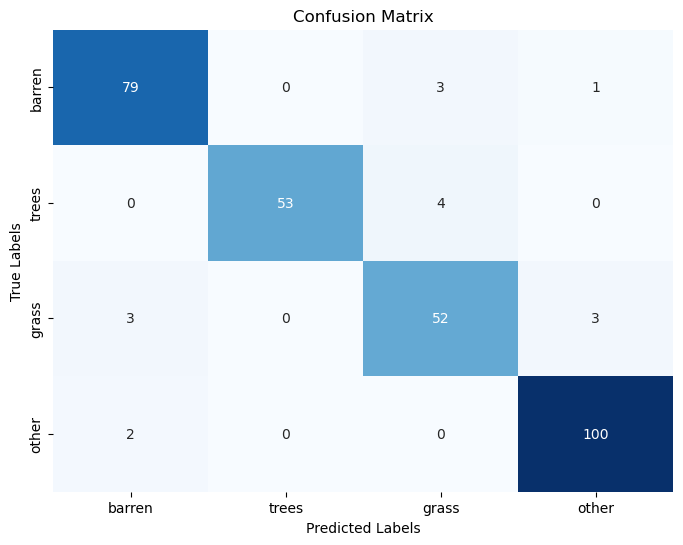

In [27]:
class_names = ['barren', 'trees', 'grass', 'other']

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar = False)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

## 16. Feature Validation - NDVI Averages

To further assess model performance, I calculated the **average NDVI** for both:

- The predicted land cover classes  
- The true class labels from the test set  

The results align closely, with **trees** having the highest NDVI and **barren** land the lowest — exactly as expected. This agreement supports that the model is not just making correct classifications by label, but doing so in a way that is **consistent with underlying vegetation characteristics**.

This provides a strong indicator that the model is performing as well as the available data allows, and that it has learned meaningful spectral differences between land cover types.


In [28]:
def get_average_NDVI(images, y):
    data = {'NDVI': [0, 0, 0, 0], 'Count': [0, 0, 0, 0]}
    df = pd.DataFrame(data)

    for i in range(len(images)):
        class_idx = y[i]
        df.iloc[class_idx, 0] += np.sum(images[i, :, :, 4])
        df.iloc[class_idx, 1] += 784  # 28x28 pixels

    return df['NDVI'] / df['Count']

def NDVI_average(X_test, X_full, y_pred, y_true_onehot):
    y_true = np.argmax(y_true_onehot, axis=1)

    df = pd.DataFrame({'Land Type': ['barren', 'trees', 'grass', 'other']})
    df['Test Average NDVI'] = get_average_NDVI(X_test, y_pred)
    df['Dataset Average NDVI'] = get_average_NDVI(X_full, y_true)

    return df

ndvi_results = NDVI_average(X_test, five_channel, y_pred, labels)
display(ndvi_results)

,Land Type,Test Average NDVI,Dataset Average NDVI
0,barren,0.026547,0.023123
1,trees,0.225581,0.226221
2,grass,0.191383,0.180750
3,other,0.084093,0.095880


## 17. Demonstration of Single Predictions

To visually demonstrate model performance, the following loop randomly samples **100 test images**. For each image:

- The **true label** and **predicted label** are printed.
- The image is shown with a **green border** if the prediction is correct, or a **red border** if incorrect.
- The **average NDVI** of the image is also printed to provide spectral context.

This demonstration uses the **ensemble model** (CNN + Random Forest).

In [30]:
# Function to add a border around an image
def add_border(image, border_color, border_width=1):
    """Adds a border around the chunk with the specified color and width"""
    image_with_border = image.copy()
    
    # Set the border pixels to the border color (e.g., RGB)
    image_with_border[:border_width, :, :] = border_color  # Top border
    image_with_border[-border_width:, :, :] = border_color  # Bottom border
    image_with_border[:, :border_width, :] = border_color  # Left border
    image_with_border[:, -border_width:, :] = border_color  # Right border
    
    return image_with_border

True Label       : other
Predicted Label  : other
Sample Index     : 202
Avg NDVI         : -0.2355


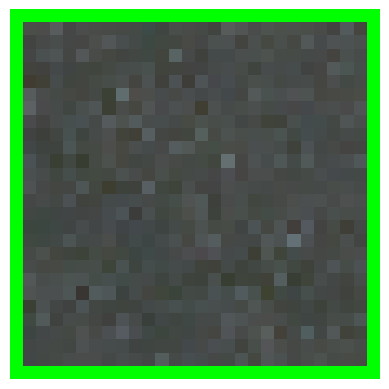

In [39]:
# Generate a list of random indices without replacement
random_indices = random.sample(range(len(X_test)), k=len(X_test))

# Convert test labels from one-hot to class index
y_test_single = np.argmax(y_test, axis=1)

# Loop through 100 random test images
for i in range(100):
    idx = random_indices[i]

    # Select image for display (RGB only) and full image (with all 5 channels)
    img_display = X_test[idx, :, :, :3]
    img_input = X_test[idx].reshape(-1, 28, 28, 5)

    # Get feature vector from CNN and predict using Random Forest
    features = feature_model.predict(img_input)
    prediction = ensemble.predict(features)

    # Clear previous plot
    clear_output(wait=True)

    # Get class names
    true_label = class_name(y_test_single[idx])
    predicted_label = class_name(prediction[0])

    # Add color-coded border
    border_color = (0, 1, 0) if true_label == predicted_label else (1, 0, 0)
    img_display = add_border(img_display, border_color, border_width=1)

    # Display info
    print("True Label       :", true_label)
    print("Predicted Label  :", predicted_label)
    print("Sample Index     :", idx)
    print("Avg NDVI         :", np.round(np.mean(X_test[idx, :, :, 4]), 4))

    # Plot image
    plt.imshow(img_display)
    plt.axis('off')
    plt.show()

    # Wait before showing next image
    time.sleep(3)


##  18. Conclusion

### **Model Evaluation**  
- While the **CNN model** alone performed well, adding a **Random Forest classifier** enhanced overall performance — especially in handling **class imbalances** and improving **generalization**.
- The **ensemble approach** (CNN + RF) consistently outperformed standalone models across most land cover types.

### **Challenges**  
- The model continues to struggle with distinguishing **grass** from **barren** land. This likely stems from:
  - The **1-meter resolution** of the imagery, which may miss finer vegetation detail.
  - The **wide visual spectrum** of grass-covered tiles, which can resemble both barren and tree-covered areas.

### **Future Work**  
- **Expand Dataset**  
  - Experimental results showed improved accuracy when increasing the sample size from 1,000 to 10,000 images. A larger dataset would likely enhance model performance further.
  
- **Data Augmentation**  
  - Techniques like **flipping**, **brightness adjustment**, and **rescaling** could help with class imbalance and increase generalization — particularly for grass and tree classes.

- **Additional Features**  
  - Including other vegetation indices (e.g., **EVI**, texture metrics) may add meaningful differentiation between similar land types.

- **Model Optimization**  
  - Further **hyperparameter tuning**, especially in the CNN architecture and RF parameters, may yield even stronger performance.


### Summary

This project demonstrates that combining **convolutional neural networks** for spatial feature extraction with **random forests** for classification is a powerful approach to land cover analysis using satellite imagery.

The ensemble model produced **high accuracy** while maintaining flexibility, interpretability, and alignment with ecological indicators like NDVI — suggesting that hybrid models can deliver both robust results and real-world insight in remote sensing applications.
